<a target="_blank" href="https://colab.research.google.com/github/lm2612/Tutorials/blob/main/2_supervised_learning_classification/2-Classification_Titanic.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Titanic: Machine learning from disaster

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this tutorial, we will use passenger data to predict who survived the shipwreck and also use our predictive model to answer the question: "what sorts of people were more likely to survive?". We will focus on passenger age, gender and socio-economic class). You can read more about the Titanic dataset [here](https://www.kaggle.com/c/titanic/overview).

First, import packages and load the data.

In [4]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(0)

In [5]:
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    filepath = "https://raw.githubusercontent.com/lm2612/Tutorials/refs/heads/main/2_supervised_learning_classification/titanic.csv"
    print(f"Notebook running in google colab. Using raw github filepath = {filepath}")

else:
    filepath = "./titanic.csv"
    print(f"Notebook running locally. Using local filepath = {filepath}")


Notebook running in google colab. Using raw github filepath = https://raw.githubusercontent.com/lm2612/Tutorials/refs/heads/main/2_supervised_learning_classification/titanic.csv


In [6]:
df = pd.read_csv(filepath)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We are interested in the "Survived" column, where are two possible outcomes: survived (1) or did not survive (0). We want to build a classifier to predict this outcome. In this tutorial, we are going to compare different classification methods, where we try to determine the factors that influence whether a passenger survived.
Specifically, we are going to investigate how the passenger class, age and sex influenced survival.

For passenger class, we are going to use dummy variables to represent the three possible states: binary variables which take on the value 0 if not true and 1 if true.

Create dummy variables for classes 1 and 2. This implicitly means that the 3rd class will be the base case that we compare to.

In [7]:
df.loc[df['Pclass']==3, 'Pclass'] = 0
df.loc[df['Pclass']==2, 'Pclass'] = 1
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,0,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,0,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,0,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Create a dummy variable equal to 1 if the passenger was female and 0 if the passenger was male.


In [8]:
df.loc[df['Sex']=='male', 'Sex'] = 0
df.loc[df['Sex']=='female', 'Sex'] = 1
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,0,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,0,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,0,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


Clean up the data - drop all variables except for the 'Age', 'Sex', 'Pclass' for our inputs and  'Survived' for our outputs. Also use `df.dropna()` to remove any NaNs from the dataset.

In [9]:
df = df[['Age', 'Sex', 'Pclass', 'Survived']]
df = df.dropna()
df.head()

,Age,Sex,Pclass,Survived
0,22.0,0,0,0
1,38.0,1,1,1
2,26.0,1,0,1
3,35.0,1,1,1
4,35.0,0,0,0


Split the data into training, validation and test data

In [12]:
print(df.shape)
training = df.iloc[0:500, :].copy()
validation = df.iloc[501:643, :].copy()
testing = df.iloc[644:714, :].copy()
training.shape, validation.shape, testing.shape

(714, 4)


((500, 4), (142, 4), (70, 4))

Set up your X and y variables


In [15]:
X = training[["Age", "Sex", "Pclass"]]
y = training["Survived"]

## Logistic regression
We will use the `sklearn.linear_model.LogisticRegression`. Read the docs here: https://scikit-learn.org/0.16/modules/generated/sklearn.linear_model.LogisticRegression.html

In [25]:
import sklearn
from sklearn.linear_model import LogisticRegression

# Set up and fit the logistic regression model

log_reg = LogisticRegression().fit(X, y)
print(f"Model score, R^2: {log_reg.score(X, y)}")
print(f"Coefficients: {log_reg.coef_}")
print(f"Intercept: {log_reg.intercept_}")

Model score, R^2: 0.802
Coefficients: [[-0.02152545  2.31497349  1.51739143]]
Intercept: [-1.4481452]


What variable is given the most relevance for a prediction?

In [ ]:
# positive coeffcient = increased probability of survival
# negative = decreased likelihood
# absolute size = strength of influence [so sex seems to have the most effect]
## but crosscheck this as coefficients are on different scales so should be treated
## with different strengths
# sex being female most significant predictor variable

## Validating our classification model
Predict on the validation dataset and estimate accuracy using one of the classification metrics from [here](https://scikit-learn.org/1.5/modules/model_evaluation.html#classification-metrics)

In [37]:
y_predicted = log_reg.predict(validation[["Age", "Sex", "Pclass"]])
y_probabilities = log_reg.predict_proba(validation[["Age", "Sex", "Pclass"]])[:,1]

from sklearn.metrics import accuracy_score, classification_report, precision_score, confusion_matrix
print(f"Accuracy: {accuracy_score(validation['Survived'], y_predicted)}")
print(f"Precision: {precision_score(validation['Survived'], y_predicted)}")
print(f"Report: {classification_report(validation['Survived'], y_predicted)}")
print(f"Confusion matrix: {confusion_matrix(validation['Survived'], y_predicted)}")
# accuracy = basic score
# precision = precision
# confusion = false positive/negatives

Accuracy: 0.795774647887324
Precision: 0.7954545454545454
Report:               precision    recall  f1-score   support

           0       0.80      0.90      0.84        87
           1       0.80      0.64      0.71        55

    accuracy                           0.80       142
   macro avg       0.80      0.77      0.78       142
weighted avg       0.80      0.80      0.79       142

Confusion matrix: [[78  9]
 [20 35]]


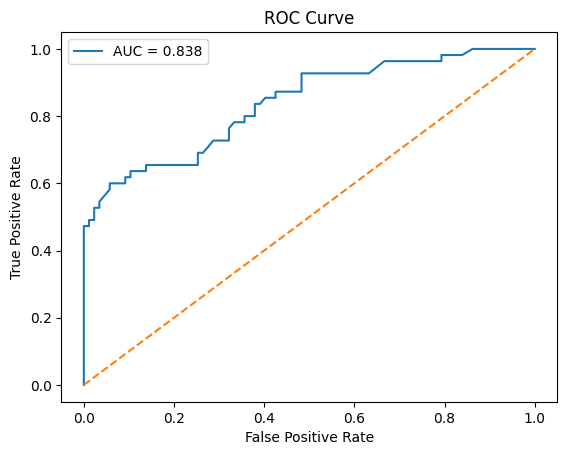

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(validation["Survived"], y_probabilities)
auc = roc_auc_score(validation["Survived"], y_probabilities)

plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")
plt.show()


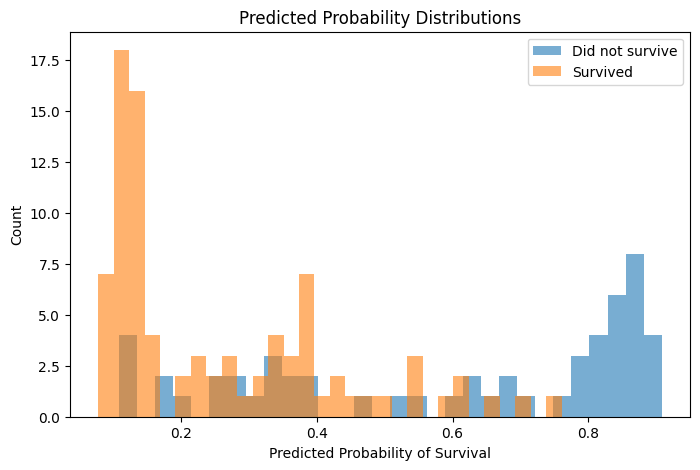

In [50]:
plt.figure(figsize=(8,5))
plt.hist(y_probabilities[validation["Survived"]==1], bins=30, alpha=0.6, label="Did not survive")
plt.hist(y_probabilities[validation["Survived"]==0], bins=30, alpha=0.6, label="Survived")
plt.xlabel("Predicted Probability of Survival")
plt.ylabel("Count")
plt.legend()
plt.title("Predicted Probability Distributions")
plt.show()


## Decision tree

Now build decision tree using `sklearn.tree.DecisionTreeClassifier` using the docs here: https://scikit-learn.org/1.5/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier. Use the entropy criterion for splitting we discussed during lectures.

In [46]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion="entropy").fit(X, y)
print(f"Model score, R^2: {tree.score(X, y)}")
print(f"Coefficients: {tree.feature_importances_}")

Model score, R^2: 0.872
Coefficients: [0.46723864 0.3593987  0.17336266]


How does the decision tree compare against the logistic regression

Accuracy: 0.7816901408450704
Precision: 0.8157894736842105
Report:               precision    recall  f1-score   support

           0       0.77      0.92      0.84        87
           1       0.82      0.56      0.67        55

    accuracy                           0.78       142
   macro avg       0.79      0.74      0.75       142
weighted avg       0.79      0.78      0.77       142

Confusion matrix: [[80  7]
 [24 31]]


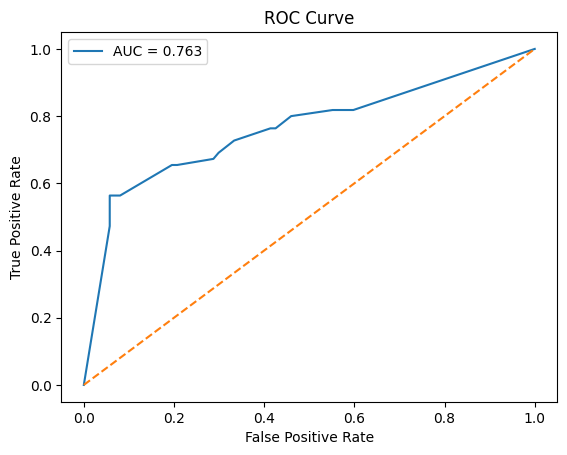

In [48]:
y_tree_pred = tree.predict(validation[["Age", "Sex", "Pclass"]])
y_tree_prob = tree.predict_proba(validation[["Age", "Sex", "Pclass"]])[:,1]

print(f"Accuracy: {accuracy_score(validation['Survived'], y_tree_pred)}")
print(f"Precision: {precision_score(validation['Survived'], y_tree_pred)}")
print(f"Report: {classification_report(validation['Survived'], y_tree_pred)}")
print(f"Confusion matrix: {confusion_matrix(validation['Survived'], y_tree_pred)}")

fpr_t, tpr_t, _ = roc_curve(validation["Survived"], y_tree_prob)
auc_t = roc_auc_score(validation["Survived"], y_tree_prob)

plt.plot(fpr_t, tpr_t, label=f"AUC = {auc_t:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")
plt.show()

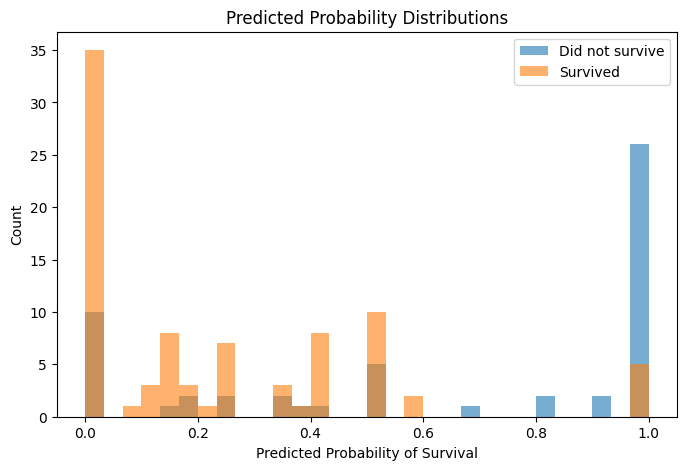

In [51]:
plt.figure(figsize=(8,5))
plt.hist(y_tree_prob[validation["Survived"]==1], bins=30, alpha=0.6, label="Did not survive")
plt.hist(y_tree_prob[validation["Survived"]==0], bins=30, alpha=0.6, label="Survived")
plt.xlabel("Predicted Probability of Survival")
plt.ylabel("Count")
plt.legend()
plt.title("Predicted Probability Distributions")
plt.show()

## KNN

Now build decision tree using `sklearn.neighbors.KNeighborsClassifier` using the docs here: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html. Try some different values of $k$ and select the one that gives the highest accuracy score.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


## Testing
Now we have the best version of each of our three models from training and validation, we can test these on teh testing dataset.

## Visualising how good the models are

Plot the accuracy score for all three models on the test dataset. Which model is best?

### Bonus question: False postives and false negatives

We can look at how often the models produce false positives and false negatives using a [confusion matrix](https://scikit-learn.org/1.5/auto_examples/model_selection/plot_confusion_matrix.html). It shows:


```
                           | Predicted Negatives (0) | Predicted Positives (1) |
--------------------------------------------------------------------------------
True Negatives (0)         | True Negatives          | False Positives         |
True Positives (1)         | False Negatives         | True Positives          |
```

We want higher values along the upper left to lower right diagonal (more true negatives / true positives) and lower values in the opposite diagonal (fewer false negatives / false positives).

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



# Compare the confusion matrices on the validation data for the logistic regression, tree and knn.